# LDA
Modelamiento de Tópicos con LDA (Latent Dirichet Allocation) para categorías de la base Barómetro Migrante

# Procesamiento de texto a través spaCy
Si usted no posee una GPU, no intente correr ninguno de los paquetes que se instalan por !pip. Se le hará una lista de requisitos y formas para correr con exito spaCy desde una GPU con arquitectura Turing:
 1. Instale la versión y el paquete de spaCy en Español para procesar texto en este lenguaje
 2. La versión de CUDA es 11.0, válido para GPUs NVIDIA con versión cuDNN 8.0+. Esto lo necesita su equipo para asignar la memoria a la tarjeta gráfica. Se instala por fuera de Python [CUDA](https://developer.nvidia.com/cuda-downloads).
 3. Instale la versión de Pytorch compatible con su versión de CUDA, recuerde que spaCy tiene transformers, esto tiene que estar especificado para que descargue los paquetes de clasificación
 4. Thinc GPU OPS y CuPy son necesarios para que el equipo reconozca la tarjeta gráfica y la vuelva accesible desde Jupyter.
 
Con esto podrá iniciar a correr modelos complejos en su equipo de trabajo, recuerde que no debe de correr ninguna línea que instale un paquete.

In [37]:
'''
!pip install lda2vec
!pip install git+https://github.com/bmabey/pyLDAvis.git@master#egg=pyLDAvis
!pip install tensorflow
!pip install keras
#Me salio un error como a esta altura
!pip install -U pip setuptools wheel
!pip install -U spacy[cuda110,transformers,lookups]
!python -m spacy download es_core_news_sm
!python -m spacy download en_core_web_sm
!python -m spacy download es_dep_news_trf
#Me salio un error como a esta altura
!pip install torch===1.7.1+cu110 torchvision===0.8.2+cu110 torchaudio===0.7.2 -f https://download.pytorch.org/whl/torch_stable.html --user
!pip install cupy-cuda110
!pip install thinc-gpu-ops
!pip install gensim
!pip install -q wordcloud
!python --version
!pip install --upgrade gensim
!pip install spacy_spanish_lemmatizer
!python -m spacy_spanish_lemmatizer download wiki
!pip install python-Levenshtein
'''

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'\n!pip install lda2vec\n!pip install git+https://github.com/bmabey/pyLDAvis.git@master#egg=pyLDAvis\n!pip install tensorflow\n!pip install keras\n#Me salio un error como a esta altura\n!pip install -U pip setuptools wheel\n!pip install -U spacy[cuda110,transformers,lookups]\n!python -m spacy download es_core_news_sm\n!python -m spacy download en_core_web_sm\n!python -m spacy download es_dep_news_trf\n#Me salio un error como a esta altura\n!pip install torch===1.7.1+cu110 torchvision===0.8.2+cu110 torchaudio===0.7.2 -f https://download.pytorch.org/whl/torch_stable.html --user\n!pip install cupy-cuda110\n!pip install thinc-gpu-ops\n!pip install gensim\n!pip install -q wordcloud\n!python --version\n!pip install --upgrade gensim\n!pip install spacy_spanish_lemmatizer\n!python -m spacy_spanish_lemmatizer download wiki\n!pip install python-Levenshtein\n'

In [1]:
#Espacio de trabajo
import tqdm
import numpy as np
from numpy.random import seed
from numpy.random import randint
#import lda2vec as l2v
import gensim
from gensim import corpora, similarities, models
from gensim.models.phrases import Phraser
#from gensim.models.wrappers import LdaMallet
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
%matplotlib inline
try:
    import seaborn
except:
    pass
import sys
import pandas as pd
import spacy
import spacy_transformers
from spacy_spanish_lemmatizer import SpacyCustomLemmatizer
import wordcloud
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from pprint import pprint
import re
import logging
import pyLDAvis
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
import matplotlib.colors as mcolors
from matplotlib.ticker import MaxNLocator
pyLDAvis.enable_notebook()
import pyLDAvis.gensim_models
import os


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JOSE\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Esto funciona si el código esta en la misma carpeta que el archivo
if (re.search('jose', os.getcwd().lower())):
    path = ''.join([os.getcwd(), '\Base_pruebas.xlsx'])
else:
    path = '/'.join([os.getcwd(), 'Base_pruebas.xlsx'])
    
base_entera = pd.read_excel(path)
base_entera

<>:3: DeprecationWarning: invalid escape sequence \B
<>:3: DeprecationWarning: invalid escape sequence \B
C:\Users\JOSE\AppData\Local\Temp/ipykernel_9024/774594630.py:3: DeprecationWarning: invalid escape sequence \B
  path = ''.join([os.getcwd(), '\Base_pruebas.xlsx'])


,Unnamed: 0,ID,Snippet,Victima,Victimario,Xenofobia,Denuncia,Positiva,Tag 666 777,Marcados
0,4,4,"@kenin_nunez @SOMOSRIOCRECID Estos venecos, ha...",0,0,1,0,0,0,1
1,7,7,"@BrianSnow007 @anGspot @iKarlyzr Eso es falso,...",1,0,1,1,0,0,1
2,9,9,"@fabrorejon Vergacion, ya se puso veneco",1,0,1,0,0,0,1
3,10,10,@Salas91Adrian @Camilousuga11 @SaqueLargoWin A...,1,0,1,0,0,0,1
4,11,11,Si cuando la generación equivocada la que no l...,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
190,1481,1481,@BluRadioCo Y los venezolanos que entran a Col...,0,0,1,0,0,0,1
191,1482,1482,@carlospc11 @BluRadioCo Esos Venecos a eso vin...,0,0,1,0,0,0,1
192,1497,1497,@UnTalSuspendido Eeehhj hp ni los venecos ps 🤣😂😂,0,0,1,0,0,0,1
193,1498,1498,@ReinaIdoRueda 80 millones!! Los venecos nos i...,0,0,1,0,0,0,1


In [3]:
df = base_entera[base_entera['Xenofobia'] == 1]
df

,Unnamed: 0,ID,Snippet,Victima,Victimario,Xenofobia,Denuncia,Positiva,Tag 666 777,Marcados
0,4,4,"@kenin_nunez @SOMOSRIOCRECID Estos venecos, ha...",0,0,1,0,0,0,1
1,7,7,"@BrianSnow007 @anGspot @iKarlyzr Eso es falso,...",1,0,1,1,0,0,1
2,9,9,"@fabrorejon Vergacion, ya se puso veneco",1,0,1,0,0,0,1
3,10,10,@Salas91Adrian @Camilousuga11 @SaqueLargoWin A...,1,0,1,0,0,0,1
4,11,11,Si cuando la generación equivocada la que no l...,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
190,1481,1481,@BluRadioCo Y los venezolanos que entran a Col...,0,0,1,0,0,0,1
191,1482,1482,@carlospc11 @BluRadioCo Esos Venecos a eso vin...,0,0,1,0,0,0,1
192,1497,1497,@UnTalSuspendido Eeehhj hp ni los venecos ps 🤣😂😂,0,0,1,0,0,0,1
193,1498,1498,@ReinaIdoRueda 80 millones!! Los venecos nos i...,0,0,1,0,0,0,1


In [4]:
seed(1)
values = list(set(randint(0, 22255, 500)))

temp=df.loc[df['ID'].isin(values)]
print(len(temp))
del values

temp.head()

5


,Unnamed: 0,ID,Snippet,Victima,Victimario,Xenofobia,Denuncia,Positiva,Tag 666 777,Marcados
8,15,15,@SdrodriguezT xenofobia?? Hermanos venezolanos...,0,0,1,0,0,0,1
38,243,243,@capimoniu @MigracionCol @BOG_ELDORADO Y con l...,0,0,1,0,0,0,1
44,269,269,@yimmys Venecos!!,0,0,1,0,0,0,1
116,818,818,@Victor_mz73 @ColombiaHumana_ Puras palabras d...,0,0,1,0,0,0,1
176,1337,1337,"@alejandraoraa Amor, primero que los venezolan...",0,0,1,0,0,0,1


In [5]:
#Eliminamos los URL: Todo lo que empieza por  HTTP
df['Clean_Text']=df['Snippet'].replace(r"http\S+", '', regex=True)
#Eliminamos todos los hashtags
df['Clean_Text']=df['Clean_Text'].replace('#\\w+', '', regex=True)
#Eliminamos los signos de puntuación repetidos dentro de los tweets
df['Clean_Text']=df['Clean_Text'].replace(r'([^0-9a-zA-Z])\1+', r'\1', regex=True)
#Eliminamos los signos de puntuación al inicio de un tweet
df['Clean_Text']=df['Clean_Text'].replace(r'^[^0-9a-zA-Z@#]+', '', regex=True)
#Eliminamos los dobles espacios
df['Clean_Text']=df['Clean_Text'].replace(r'()\1+', r'\1\1', regex=True)
#Eliminamos las letras repetivas dentro de las palabras
df['Clean_Text']=df['Clean_Text'].replace(r'(.)\1+', r'\1\1', regex=True)
#Eliminamos las letras repetivas dentro de las palabras
df['Clean_Text']=df['Clean_Text'].replace(r'([A-Z a-z]+)\1+', r'\1\1', regex=True)
# Quitar las comillas de los textos
df['Clean_Text']=df['Clean_Text'].replace('"', '', regex=True)
# Remover puntuaciones innecesarias
df['Clean_Text'] = df['Clean_Text'].map(lambda x: re.sub('[,\.!?]', '', x))
# Remover mayúsculas de inicio de texto
df['Clean_Text'] = df['Clean_Text'].map(lambda x: x.lower())
df=df.reset_index(drop=True)
df=df.reset_index()
df = df.astype({"Clean_Text": str})
df.head(11)

<>:18: DeprecationWarning: invalid escape sequence \.
<>:18: DeprecationWarning: invalid escape sequence \.
C:\Users\JOSE\AppData\Local\Temp/ipykernel_9024/1428317871.py:18: DeprecationWarning: invalid escape sequence \.
  df['Clean_Text'] = df['Clean_Text'].map(lambda x: re.sub('[,\.!?]', '', x))


,index,Unnamed: 0,ID,Snippet,Victima,Victimario,Xenofobia,Denuncia,Positiva,Tag 666 777,Marcados,Clean_Text
0,0,4,4,"@kenin_nunez @SOMOSRIOCRECID Estos venecos, ha...",0,0,1,0,0,0,1,@kenin_nunez @somosriocrecid estos venecos has...
1,1,7,7,"@BrianSnow007 @anGspot @iKarlyzr Eso es falso,...",1,0,1,1,0,0,1,@briansnow007 @angspot @ikarlyzr eso es falso ...
2,2,9,9,"@fabrorejon Vergacion, ya se puso veneco",1,0,1,0,0,0,1,@fabrorejon vergacion ya se puso veneco
3,3,10,10,@Salas91Adrian @Camilousuga11 @SaqueLargoWin A...,1,0,1,0,0,0,1,@salas91adrian @camilousuga11 @saquelargowin a...
4,4,11,11,Si cuando la generación equivocada la que no l...,0,0,1,0,0,0,1,si cuando la generación equivocada la que no l...
5,5,12,12,"@mitsukiruki Douglas Bravo, un guerrillero com...",0,0,1,0,0,0,1,@mitsukiruki douglas bravo un guerrillero comu...
6,6,13,13,Están peor que los venecos estos hijos de puta.,0,0,1,0,0,0,1,están peor que los venecos estos hijos de puta
7,7,14,14,"De la que me salve, esperanza con Cali, ratas ...",0,1,1,0,0,0,1,de la que me salve esperanza con cali ratas co...
8,8,15,15,@SdrodriguezT xenofobia?? Hermanos venezolanos...,0,0,1,0,0,0,1,@sdrodriguezt xenofobia hermanos venezolanos n...
9,9,23,23,@FontirroigPablo @norte_canal Con todo el resp...,0,0,1,0,0,0,1,@fontirroigpablo @norte_canal con todo el resp...


In [6]:
#Eliminamos algunos autores
df['Clean_Text']=df['Clean_Text'].replace(r'@\w+', '', regex=True)
df['Clean_Text']=df['Clean_Text'].str.strip()
df.head(11)

,index,Unnamed: 0,ID,Snippet,Victima,Victimario,Xenofobia,Denuncia,Positiva,Tag 666 777,Marcados,Clean_Text
0,0,4,4,"@kenin_nunez @SOMOSRIOCRECID Estos venecos, ha...",0,0,1,0,0,0,1,estos venecos hasta en la sopa 👎🤢
1,1,7,7,"@BrianSnow007 @anGspot @iKarlyzr Eso es falso,...",1,0,1,1,0,0,1,eso es falso en venezuela así como en todos lo...
2,2,9,9,"@fabrorejon Vergacion, ya se puso veneco",1,0,1,0,0,0,1,vergacion ya se puso veneco
3,3,10,10,@Salas91Adrian @Camilousuga11 @SaqueLargoWin A...,1,0,1,0,0,0,1,aprende venezolano
4,4,11,11,Si cuando la generación equivocada la que no l...,0,0,1,0,0,0,1,si cuando la generación equivocada la que no l...
5,5,12,12,"@mitsukiruki Douglas Bravo, un guerrillero com...",0,0,1,0,0,0,1,douglas bravo un guerrillero comunista venezol...
6,6,13,13,Están peor que los venecos estos hijos de puta.,0,0,1,0,0,0,1,están peor que los venecos estos hijos de puta
7,7,14,14,"De la que me salve, esperanza con Cali, ratas ...",0,1,1,0,0,0,1,de la que me salve esperanza con cali ratas co...
8,8,15,15,@SdrodriguezT xenofobia?? Hermanos venezolanos...,0,0,1,0,0,0,1,xenofobia hermanos venezolanos no señores cuan...
9,9,23,23,@FontirroigPablo @norte_canal Con todo el resp...,0,0,1,0,0,0,1,con todo el respeto que ustedes se merecen ami...


In [7]:
"""
from matplotlib.ticker import MaxNLocator
usuarios=df['Clean_Text'].str.extractall(r'(@\w+)').value_counts()
temp=pd.DataFrame(usuarios, columns=['count']).reset_index().reset_index()

def format_fn(tick_val, tick_pos):
    labels=list(temp[0])
    if int(tick_val) in temp['index']:
        return labels[int(tick_val)]
    else:
        return ''

fig, ax = plt.subplots()
ax.hist(temp['index'], weights=temp['count'])
ax.set_xticklabels(ax.get_xticks(), rotation = 45)
ax.xaxis.set_major_formatter(format_fn)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()
"""

<>:1: DeprecationWarning: invalid escape sequence \w
<>:1: DeprecationWarning: invalid escape sequence \w
C:\Users\JOSE\AppData\Local\Temp/ipykernel_9024/3873206139.py:1: DeprecationWarning: invalid escape sequence \w
  """


"\nfrom matplotlib.ticker import MaxNLocator\nusuarios=df['Clean_Text'].str.extractall(r'(@\\w+)').value_counts()\ntemp=pd.DataFrame(usuarios, columns=['count']).reset_index().reset_index()\n\ndef format_fn(tick_val, tick_pos):\n    labels=list(temp[0])\n    if int(tick_val) in temp['index']:\n        return labels[int(tick_val)]\n    else:\n        return ''\n\nfig, ax = plt.subplots()\nax.hist(temp['index'], weights=temp['count'])\nax.set_xticklabels(ax.get_xticks(), rotation = 45)\nax.xaxis.set_major_formatter(format_fn)\nax.xaxis.set_major_locator(MaxNLocator(integer=True))\n\nplt.show()\n"

In [46]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df.Clean_Text.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])


# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
spanish_stopwords=stopwords.words('spanish')
spanish_stopwords.remove('no')
special_characters = "áéóíú"
#Result = [Number ** 2 for list in Numbers for Number in list if Number %2 == 0]
# Example: $tackoverflow
for palabra in spanish_stopwords:
    for letra in palabra:
        if letra in special_characters:
            escogida = palabra
            # Convertir la palabra a sin tilde
            if letra == 'á':
                nueva_palabra = escogida.replace(letra, 'a')
            elif letra == 'é':
                nueva_palabra = escogida.replace(letra, 'e')
            elif letra == 'í':
                nueva_palabra = escogida.replace(letra, 'i')
            elif letra == 'ó':
                nueva_palabra = escogida.replace(letra, 'o')
            else:
                nueva_palabra = escogida.replace(letra, 'u')
            spanish_stopwords.append(nueva_palabra)
spanish_stopwords.extend(['solo','sólo','así','asi','si','sí','pa','and','re','ser','haber','ta','va'])
spanish_stopwords = set(spanish_stopwords)
spanish_stopwords = list(spanish_stopwords)
def process_words(texts, stop_words=spanish_stopwords):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in gensim.utils.simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load("es_dep_news_trf", exclude=["ner", "parser", "lemmatizer"])
    lemmatizer_spa = SpacyCustomLemmatizer()
    nlp.add_pipe("spanish_lemmatizer", name = 'lemmatizer', after = 'attribute_ruler')
    print(nlp.pipe_names)
    print(texts)
    docs = list()
    palabras_unir = ['mismo', 'hacer', 'no']
    for sent in texts:
        print(sent)
        # Hay dos casos: 
        for pos in range(len(sent)):
            if sent[pos] in palabras_unir:
                # La palabra está al final
                if pos == len(sent):
                    sent[pos] = "_".join([sent[pos-1],sent[pos]])
                    sent[pos-1] = ''
                # La palabra está en la mitad 
                else:
                    sent[pos] = "_".join([sent[pos],sent[pos+1]])
                    sent[pos+1] = ''
        doc = " ".join(sent)
        docs.append(doc)
    spacy_docs = list()
    for doc in tqdm.tqdm(nlp.pipe(docs), total=len(docs)):
        texts_out.append([token.lemma_ for token in doc])
    texts_out = [[word for word in gensim.utils.simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]
    return texts_out
data_ready = process_words(data_words)  # processed Text Data!
data_ready

<>:3: DeprecationWarning: invalid escape sequence \S
<>:4: DeprecationWarning: invalid escape sequence \s
<>:3: DeprecationWarning: invalid escape sequence \S
<>:4: DeprecationWarning: invalid escape sequence \s
C:\Users\JOSE\AppData\Local\Temp/ipykernel_9024/3411273480.py:3: DeprecationWarning: invalid escape sequence \S
  sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
C:\Users\JOSE\AppData\Local\Temp/ipykernel_9024/3411273480.py:4: DeprecationWarning: invalid escape sequence \s
  sent = re.sub('\s+', ' ', sent)  # remove newline chars


[['estos', 'venecos', 'hasta', 'en', 'la', 'sopa']]
['transformer', 'morphologizer', 'attribute_ruler', 'lemmatizer']
[['venecos', 'sopa'], ['falso', 'venezuela', 'paises', 'xenofobia', 'nacido', 'venezuela', 'hijo', 'padres', 'colombianos', 'carne', 'propia', 'vivi', 'xenofobia', 'venezolanos'], ['vergacion', 'puso', 'veneco'], ['aprende', 'venezolano'], ['generacion', 'equivocada', 'no', 'gusta', 'trabajar', 'no', 'estudiar', 'mendigando', 'famoso', 'socialismo', 'pregunte', 'esquina', 'veneco', 'pais', 'socialista'], ['douglas', 'bravo', 'guerrillero', 'comunista', 'venezolano', 'llorando', 'mares'], ['peor', 'venecos', 'hijos', 'puta'], ['salve', 'esperanza', 'cali', 'ratas', 'cero', 'fisico', 'pique', 'venezolanos', 'hijueputas'], ['xenofobia', 'hermanos', 'venezolanos', 'no', 'senores', 'roban', 'matan', 'senores', 'acorde', 'ustedes', 'no', 'robado', 'petardos', 'apoyan', 'gente', 'extranjera'], ['respeto', 'ustedes', 'merecen', 'amigos', 'chilenos', 'vieron', 'cara', 'bobos', '

100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [00:52<00:00,  3.73it/s]


[['venecos', 'sopa'],
 ['falso',
  'venezuela',
  'paises',
  'xenofobia',
  'nacido',
  'venezuela',
  'hijo',
  'padre',
  'colombiano',
  'carne',
  'propio',
  'vivi',
  'xenofobia',
  'venezolano'],
 ['vergacion', 'poner', 'veneco'],
 ['aprender', 'venezolano'],
 ['generacion',
  'equivocado',
  'no_gusta',
  'trabajar',
  'no_estudiar',
  'mendigar',
  'famoso',
  'socialismo',
  'preguntar',
  'esquina',
  'veneco',
  'pais',
  'socialista'],
 ['douglas',
  'bravo',
  'guerrillero',
  'comunista',
  'venezolano',
  'llorar',
  'mar'],
 ['peor', 'venecos', 'hijo', 'puta'],
 ['salvar',
  'esperanza',
  'cali',
  'rata',
  'cero',
  'fisico',
  'pique',
  'venezolano',
  'hijueputas'],
 ['xenofobia',
  'hermano',
  'venezolano',
  'no_senores',
  'robar',
  'matar',
  'senores',
  'acorde',
  'ustedes',
  'no_robado',
  'petardo',
  'apoyar',
  'gente',
  'extranjero'],
 ['respeto',
  'ustedes',
  'merecer',
  'amigo',
  'chileno',
  'ver',
  'cara',
  'bobos',
  'venecos',
  'aca'

# Análisis descriptivo
Gráficas despúes del preproceso

In [47]:
# Create Dictionary
dictionary = corpora.Dictionary(data_ready)
# Create Corpus: Term Document Frequency
corpus = [dictionary.doc2bow(text) for text in data_ready]
dictionary.save('tweets_x.dict');
corpora.MmCorpus.serialize('tweets_x.mm', corpus)
corpora.SvmLightCorpus.serialize('tweets_x.svmlight', corpus)
corpora.BleiCorpus.serialize('tweets_x.lda-c', corpus)
corpora.LowCorpus.serialize('tweets_x.low', corpus)
print('--------CORPUS----------')
print(corpus[:1])
##Then the dictionary and corpus can be used to train using LDA
np.random.seed(123456)
mm = corpora.MmCorpus('tweets_x.mm')
num_topics=10
%time lda = gensim.models.ldamodel.LdaModel(corpus=mm, id2word=dictionary, num_topics=num_topics, update_every=0, passes=10, alpha=[0.01]*num_topics, eta=[0.01]*len(dictionary.keys()))

--------CORPUS----------
[[(0, 1), (1, 1)]]
Wall time: 614 ms


In [48]:
[[(dictionary[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('sopa', 1), ('venecos', 1)]]

In [49]:
pprint(lda.print_topics())
doc_lda = lda[corpus]

[(0,
  '0.037*"venecos" + 0.030*"venezolano" + 0.022*"ver" + 0.015*"colombia" + '
  '0.015*"veneco" + 0.015*"llegar" + 0.015*"ayudar" + 0.007*"bobos" + '
  '0.007*"respeto" + 0.007*"merecer"'),
 (1,
  '0.060*"venezolano" + 0.021*"venecos" + 0.021*"colombia" + 0.011*"venezuela" '
  '+ 0.011*"trabajar" + 0.011*"veneco" + 0.011*"creer" + 0.011*"pais" + '
  '0.011*"venir" + 0.011*"pasa"'),
 (2,
  '0.057*"venezolano" + 0.021*"colombia" + 0.016*"venecos" + 0.016*"mal" + '
  '0.016*"pais" + 0.010*"llevar" + 0.010*"tan" + 0.010*"menos" + 0.010*"vez" + '
  '0.010*"problema"'),
 (3,
  '0.055*"veneco" + 0.031*"venezolano" + 0.024*"venecos" + 0.018*"rata" + '
  '0.012*"llegar" + 0.012*"hablar" + 0.009*"tal" + 0.006*"lindo" + '
  '0.006*"riesgo" + 0.006*"no_comida"'),
 (4,
  '0.048*"venezolano" + 0.024*"venecos" + 0.018*"pais" + 0.018*"huir" + '
  '0.018*"bueno" + 0.012*"robar" + 0.012*"limosna" + 0.012*"gente" + '
  '0.012*"pedir" + 0.012*"mismo"'),
 (5,
  '0.080*"venezolano" + 0.031*"venecos" + 0

In [50]:
vis = pyLDAvis.gensim_models.prepare(topic_model=lda, corpus=corpus, dictionary=dictionary)
pyLDAvis.display(vis)

C:\Users\JOSE\anaconda3\envs\nltkenv\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [51]:
# Archivo HTML
pyLDAvis.save_html(vis, 'ldax.html')

# Compute Model Perplexity and Coherence Score
Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is. Topic coherence score, in particular, has been more helpful.

In [52]:
# Compute Perplexity
print('\nPerplexity: ', lda.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda, texts=data_ready, dictionary=dictionary, coherence='c_v')
with np.errstate(invalid='ignore'):
    coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)



Perplexity:  -8.308629660897951

Coherence Score:  0.4733802382238615


# LDA Mallet

In [53]:
'''
mallet_path = '/Users/diegoalejandrobermudezsierra/OneDrive - Universidad de los Andes/BX/LDA/mallet' # update this path
import os
os.environ['MALLET_HOME'] = '/Users/diegoalejandrobermudezsierra/OneDrive - Universidad de los Andes/BX/LDA/mallet-2.0.8'
print('----MALLET----')
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=dictionary)
'''

"\nmallet_path = '/Users/diegoalejandrobermudezsierra/OneDrive - Universidad de los Andes/BX/LDA/mallet' # update this path\nimport os\nos.environ['MALLET_HOME'] = '/Users/diegoalejandrobermudezsierra/OneDrive - Universidad de los Andes/BX/LDA/mallet-2.0.8'\nprint('----MALLET----')\nldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=dictionary)\n"

In [54]:
'''
# Convert mallet to gensim type
mallet_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)
# Compute Perplexity
print('\nPerplexity: ', mallet_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=df['Clean_Text'].to_list(), dictionary=dictionary, coherence='c_v')
with np.errstate(invalid='ignore'):
    coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)
'''

"\n# Convert mallet to gensim type\nmallet_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)\n# Compute Perplexity\nprint('\nPerplexity: ', mallet_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.\n\n# Show Topics\npprint(ldamallet.show_topics(formatted=False))\n\n# Compute Coherence Score\ncoherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=df['Clean_Text'].to_list(), dictionary=dictionary, coherence='c_v')\nwith np.errstate(invalid='ignore'):\n    coherence_ldamallet = coherence_model_ldamallet.get_coherence()\nprint('\nCoherence Score: ', coherence_ldamallet)\n"

# Optimal number of topics

In [55]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=mm, id2word=dictionary, num_topics=num_topics, update_every=0, passes=10, alpha=[0.01]*num_topics, eta=[0.01]*len(dictionary.keys()))
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [56]:
# Can take a long time to run.
%time model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=mm, texts=data_ready, start=4, limit=20, step=2)

Wall time: 28.8 s


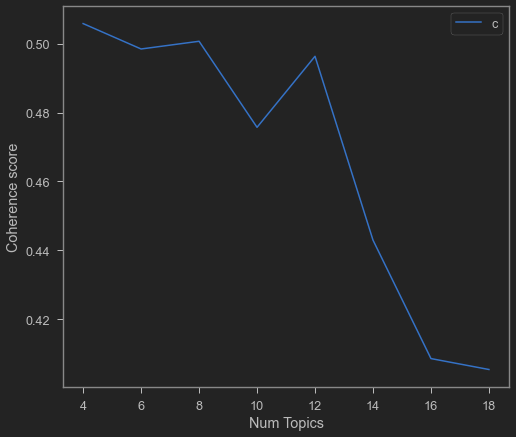

In [57]:
# Show graph
limit=20; start=4; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [58]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 2))

Num Topics = 4  has Coherence Value of 0.51
Num Topics = 6  has Coherence Value of 0.5
Num Topics = 8  has Coherence Value of 0.5
Num Topics = 10  has Coherence Value of 0.48
Num Topics = 12  has Coherence Value of 0.5
Num Topics = 14  has Coherence Value of 0.44
Num Topics = 16  has Coherence Value of 0.41
Num Topics = 18  has Coherence Value of 0.41


In [59]:
# Select the model and print the topics
optimal_model = model_list[0]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.062*"venezolano" + 0.025*"venecos" + 0.015*"colombia" + '
  '0.014*"colombiano" + 0.014*"bueno" + 0.011*"bien" + 0.011*"merecer" + '
  '0.011*"pais" + 0.009*"pedir" + 0.009*"salir"'),
 (1,
  '0.060*"venezolano" + 0.019*"venecos" + 0.016*"hacer" + 0.014*"pais" + '
  '0.012*"decir" + 0.010*"bien" + 0.008*"veneco" + 0.008*"colombiano" + '
  '0.008*"ahora" + 0.006*"bueno"'),
 (2,
  '0.065*"venezolano" + 0.019*"venecos" + 0.018*"colombia" + 0.015*"pais" + '
  '0.010*"hacer" + 0.010*"trabajar" + 0.010*"mierda" + 0.008*"cubano" + '
  '0.008*"querer" + 0.008*"comer"'),
 (3,
  '0.046*"venezolano" + 0.044*"venecos" + 0.025*"veneco" + 0.013*"colombia" + '
  '0.013*"llegar" + 0.010*"xenofobia" + 0.010*"problema" + 0.010*"mejor" + '
  '0.008*"hijo" + 0.008*"peor"')]


In [60]:
visx = pyLDAvis.gensim_models.prepare(topic_model=optimal_model, corpus=corpus, dictionary=dictionary, mds='mmds')
pyLDAvis.display(visx)

In [ ]:
# Archivo HTML
pyLDAvis.save_html(visx, 'ldax2.html')

In [28]:
# supporting function
def compute_coherence_perplexity_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b,
                                           workers=7)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_ready, dictionary=dictionary, coherence='c_v')
    
    return (coherence_model_lda.get_coherence(),lda_model.log_perplexity(corpus))
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# Validation sets
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': [],
                 'Perplexity': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm(total=540)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    (cv, pp) = compute_coherence_perplexity_values(corpus=corpus_sets[i], dictionary=dictionary, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    model_results['Perplexity'].append(pp)
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()

100%|████████████████████████████████████████████████████████████████████████████████| 540/540 [48:11<00:00,  5.36s/it]


In [29]:
tabla_tunning = pd.read_csv('lda_tuning_results.csv')
tabla_tunning = tabla_tunning.sort_values(by = 'Coherence')
tabla_tunning

,Validation_Set,Topics,Alpha,Beta,Coherence,Perplexity
523,100% Corpus,10,0.61,0.9099999999999999,0.301273,-7.343755
58,75% Corpus,3,asymmetric,0.9099999999999999,0.302387,-6.724720
493,100% Corpus,9,0.61,0.9099999999999999,0.311577,-7.269156
57,75% Corpus,3,asymmetric,0.61,0.320129,-6.740918
271,100% Corpus,2,0.01,0.31,0.320796,-6.751839
...,...,...,...,...,...,...
238,75% Corpus,9,asymmetric,0.9099999999999999,0.548487,-6.893647
178,75% Corpus,7,asymmetric,0.9099999999999999,0.568243,-6.851293
447,100% Corpus,7,asymmetric,0.61,0.599066,-6.878829
177,75% Corpus,7,asymmetric,0.61,0.630029,-6.858213


In [46]:
tabla_tunning.to_excel('mejor_modelo.xlsx')

C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:


#corpus = corpora.MmCorpus('tweets_x.mm')
#dictionary = corpora.Dictionary('tweets_x.dict')
# EL mejor modelo

lda_final_model = gensim.models.LdaMulticore(corpus=mm,
                                             id2word=dictionary,
                                             num_topics=9,
                                             random_state=100,
                                             chunksize=100,
                                             passes=10,
                                             alpha=0.31,
                                             eta=0.61)

[[(dictionary[id], freq) for id, freq in cp] for cp in corpus[:1]]

pprint(lda_final_model.print_topics())
doc_lda = lda_final_model[corpus]

visxx = pyLDAvis.gensim.prepare(topic_model=lda_final_model, corpus=corpus, dictionary=dictionary)
pyLDAvis.display(visxx)


C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\JOSE\anaconda3\lib\asyncio\events.py:81: DeprecationWarning: `run_cell_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  self._context.run(self._callback, *self._args)


[(0,
  '0.072*"venezolano" + 0.038*"no" + 0.022*"colombia" + 0.021*"país" + '
  '0.013*"  " + 0.012*"colombiano" + 0.012*"tener" + 0.011*"hacer" + '
  '0.007*"si" + 0.007*"venir"'),
 (1,
  '0.150*"venecos" + 0.029*"mierda" + 0.016*"hijueputa" + 0.016*"  " + '
  '0.012*"hp" + 0.011*"puta" + 0.011*"hijo" + 0.010*"plaga" + 0.008*"maldito" '
  '+ 0.008*"pa"'),
 (2,
  '0.004*"trata" + 0.004*"joven" + 0.004*"ojala" + 0.003*"campaña" + '
  '0.003*"rápido" + 0.003*"excelente" + 0.003*"real" + 0.003*"plan" + '
  '0.003*"valer" + 0.003*"minuto"'),
 (3,
  '0.006*"paro" + 0.005*"periodista" + 0.005*"coronavirus" + 0.004*"realizar" '
  '+ 0.003*"presencia" + 0.003*"denunciar" + 0.002*"acoger" + 0.002*"dictador" '
  '+ 0.002*"muestra" + 0.002*"permiso"'),
 (4,
  '0.005*"🏻\u200d" + 0.005*"dolar" + 0.005*"ecuador" + 0.004*"mañana" + '
  '0.004*"ignorante" + 0.004*"metido" + 0.003*"mamar" + 0.003*"perú" + '
  '0.003*"cansar" + 0.002*"dolor"'),
 (5,
  '0.028*"veneca" + 0.019*"hptas" + 0.018*"venecas" + 

In [35]:
pyLDAvis.save_html(visxx, 'ldax3.html')

C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [47]:
# Compute Perplexity
print('\nPerplexity: ', lda_final_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_final_model, texts=data_ready, dictionary=dictionary, coherence='c_v')
with np.errstate(invalid='ignore'):
    coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Perplexity:  -7.860545734350947

Coherence Score:  0.515500834428575


# Finding the dominant topic in each sentence

In [42]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()
    
    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_final_model, corpus=corpus, texts=df['Snippet'])

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.5663,"venecos, mierda, hijueputa, , hp, puta, hijo...","@kenin_nunez @SOMOSRIOCRECID Estos venecos, ha..."
1,1,0.0,0.8600,"venezolano, no, colombia, país, , colombiano...","@BrianSnow007 @anGspot @iKarlyzr Eso es falso,..."
2,2,6.0,0.4184,"veneco, malparido, hpta, puro, , chiste, mue...","@fabrorejon Vergacion, ya se puso veneco"
3,3,8.0,0.5610,"venezolano, no, si, tener, decir, hacer, robar...",@Salas91Adrian @Camilousuga11 @SaqueLargoWin A...
4,4,8.0,0.5112,"venezolano, no, si, tener, decir, hacer, robar...",Si cuando la generación equivocada la que no l...
5,5,6.0,0.4359,"veneco, malparido, hpta, puro, , chiste, mue...","@mitsukiruki Douglas Bravo, un guerrillero com..."
6,6,1.0,0.5135,"venecos, mierda, hijueputa, , hp, puta, hijo...",Están peor que los venecos estos hijos de puta.
7,7,8.0,0.4506,"venezolano, no, si, tener, decir, hacer, robar...","De la que me salve, esperanza con Cali, ratas ..."
8,8,8.0,0.8598,"venezolano, no, si, tener, decir, hacer, robar...",@SdrodriguezT xenofobia?? Hermanos venezolanos...
9,9,8.0,0.6821,"venezolano, no, si, tener, decir, hacer, robar...",@FontirroigPablo @norte_canal Con todo el resp...


In [43]:
df_dominant_topic.to_excel('Topico_dominante_por_frase_snippet.xlsx')

C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Find the most representative document for each topic

In [44]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9215,"venezolano, no, colombia, país, , colombiano...",Sin ese 4% que los venezolanos aportan estaría...
1,1.0,0.8269,"venecos, mierda, hijueputa, , hp, puta, hijo...",@elviejomiguelc Tremendo coñazo.. Disculpe me ...
2,2.0,0.8136,"trata, joven, ojala, campaña, rápido, excelent...","@CaracolRadio Veneco,esto es lo que heredamos ..."
3,3.0,0.8104,"paro, periodista, coronavirus, realizar, prese...",HIDRUITANGO..GRAN FRACASO DE LA INFENIERIA COL...
4,4.0,0.8117,"🏻‍, dolar, ecuador, mañana, ignorante, metido,...",Caracas FC avanzó a la tercera fase de la Copa...


In [45]:
sent_topics_sorteddf_mallet.to_excel('tweets_representativos_por_topico_snippet.xlsx')

C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Topic distribution across documents

In [40]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,1.0,"venecos, mierda, hijueputa, , hp, puta, hijo...",13305.0,0.4372
1.0,0.0,"venezolano, no, colombia, país, , colombiano...",2863.0,0.0941
2.0,6.0,"veneco, malparido, hpta, puro, , chiste, mue...",167.0,0.0055
3.0,8.0,"venezolano, no, si, tener, decir, hacer, robar...",232.0,0.0076
4.0,8.0,"venezolano, no, si, tener, decir, hacer, robar...",195.0,0.0064
...,...,...,...,...
30430.0,0.0,"venezolano, no, colombia, país, , colombiano...",NaN,NaN
30431.0,0.0,"venezolano, no, colombia, país, , colombiano...",NaN,NaN
30432.0,0.0,"venezolano, no, colombia, país, , colombiano...",NaN,NaN
30433.0,0.0,"venezolano, no, colombia, país, , colombiano...",NaN,NaN


In [41]:
df_dominant_topics.to_excel('distribución_de_topicos_a_traves_de_documentos.xlsx')

C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
